In [1]:
import os
import operator
import numpy as np
import pandas as pd
import sys
import colorcet as cc
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle

## __SI:__ Antimicrobial resistance level and conjugation permissiveness shape plasmid distribution in clinical enterobacteria

### 3. Modeling plasmid dynamics in multistrain population

In this notebook, we extend the plasmid population dynamics model to include multiple bacterial strains, with each strain consisting of a mix of plasmid-bearing and plasmid-free cells. These cells compete for a single, limiting resource within a homogeneous environment. Our model assumes strictly competitive interactions between strains, without any metabolic exchanges. Moreover, our model enables the simulation of horizontal plasmid transfers between different strains through conjugation. By incorporating multistrain dynamics, we create a framework to explore the population dynamics of plasmids within diverse bacterial communities under a variety of selective pressures and population structures.



### Experimental parameters

In [4]:


sys.path.insert(0, 'src/')
from pOXA48_S1 import *
from pOXA48_S2 import *

%run src/pOXA48_parameters
print_expe_params(expe_params)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Experimental Parameters:
------------------------------------------------
	Initial bacterial density (B0): 1000000.0
	Maximum drug concentration (A_max): 131072
	Antibiotic degradation rates (alphas): [1.e-10 1.e-12]
	Length of experiment (T): 24
	Initial resource concentration (S0): 1.0
	Resource decay rate (d): 0.1
	Extinction threshold: 1.0
------------------------------------------------



For each strain $i$, we denote the densities of plasmid-bearing and plasmid-free subpopulations as $B_{pi}$ and $B_i$, respectively. The entire bacterial community at a given time $t$ can be symbolically expressed as a vector: $\mathbf{B}(t) = (B_{p1}(t), B_{p2}(t), ..., B_{pM}(t), B_1(t), B_2(t), ..., B_M(t))$.

As each cell consumes the limiting resource at rates defined by their individual growth kinetic parameters, the rate of resource $R$ change over time is dictated by:
$$
\frac{{dR}}{{dt}} = -\sum_{i=1}^{M} (u_{pi}(R(t))B_{pi}(t) + u_i(R(t))B_i(t)) - dR.
$$

We postulate that antibiotic molecules are deactivated at a rate proportional to the total bacterial population and the environmental drug concentration. This is mathematically represented as:
$$
\frac{{dA}}{{dt}} = -\sum_{i=1}^{M} (B_{pi}(t) + B_i(t)) - dA.
$$

Given that plasmid conjugation is contingent on the recipient cell, the strain $i$'s receptiveness towards the pOXA-48 plasmid is defined by $i$. Therefore, the plasmid-bearing subpopulation's growth of strain $i$ hinges on the collective contribution of all plasmid-bearing populations:
$$\frac{{dB_{pi}}}{{dt}} = p_iu_{pi}(R)(1 - p_iA)B_{pi} + \sum_{j=1}^{M} B_{pj} - dB_{pi}.$$

Likewise, the population dynamics of the plasmid-free strain $i$ can be captured as:
$$\frac{{dB_i}}{{dt}} = u(R)(1 - A)B_i + p_iu_{pi}(R)B_{pi} - \sum_{j=1}^{M} B_{pj} - dB_i.$$

The initial conditions for the simulations stem from a competition experiment where all strains in the community, both plasmid-bearing and plasmid-free, are introduced at equivalent initial densities at time $t=0$.

In [5]:

def dB_conj(B_WT, B_TC, conj_exponent):
    if np.isnan(conj_exponent): # Below detectable limits
        conj_rate = 0
    else:
        conj_rate = 10**conj_exponent
    ret = 0
    if np.size(B_TC) == 1:
        ret = conj_rate * B_WT * B_TC  # Changed Bdonor to B_TC because in this case B_TC is a float
    else:
        for Bdonor in B_TC:
            ret += conj_rate * B_WT * Bdonor
    return ret

def fMultistrain(t, y, params):
    S = y[0]
    A = y[1]
    num_strains = int(len(params['strain']) / 2)
    B_TC = y[2:num_strains + 2]
    B_WT = y[num_strains + 2:]

    uStot = 0
    dB = np.zeros(2 * num_strains)

    # For plasmid-bearing (TC)
    for i in range(num_strains):

        uSi_TC = uS(S, params['VKm'].iloc[i])
        uStot += uSi_TC * B_TC[i]

        dB_TC_growth = params['rho'].iloc[i] * uSi_TC * B_TC[i]
        dB_TC_seg = params['rho'].iloc[i] * uSi_TC * B_TC[i] * params['seg_rate'].iloc[i]

        db_MIC_TC = params['kappa'].iloc[i]
        dB_TC_kill = dB_kill(A, B_TC[i], db_MIC_TC, params.attrs['A_max'])

        conj_permissiveness=params['conj_rate'].iloc[i+num_strains] #permissiveness of WT
        dB_TC_conj = dB_conj(B_WT[i], B_TC, conj_permissiveness)


        dB[i] = dB_TC_growth + dB_TC_conj - dB_TC_seg - dB_TC_kill

    # For plasmid-free (WT)
    for i in range(num_strains, 2*num_strains):

        uSi_WT = uS(S, params['VKm'].iloc[i])
        uStot += uSi_WT * B_WT[i-num_strains]

        dB_WT_growth = params['rho'].iloc[i] * uSi_WT * B_WT[i-num_strains]

        db_MIC_WT = params['kappa'].iloc[i]
        dB_WT_kill = dB_kill(A, B_WT[i-num_strains], db_MIC_WT, params.attrs['A_max'])

        uSi_TC = uS(S, params['VKm'].iloc[i-num_strains])
        dB_WT_seg= params['rho'].iloc[i - num_strains] * uSi_TC * B_TC[i - num_strains] * params['seg_rate'].iloc[i-num_strains]

        conj_permissiveness=params['conj_rate'].iloc[i] #permissiveness of WT
        dB_WT_conj = dB_conj(B_WT[i-num_strains], B_TC, conj_permissiveness)

        dB[i] = dB_WT_growth - dB_WT_conj - dB_WT_kill + dB_WT_seg

    dS =  - uStot
    dA = -A * (params.attrs['alphas'][0] * np.sum(B_TC) + params.attrs['alphas'][1] * np.sum(B_WT))

    return np.concatenate(([dS], [dA], dB))


In [6]:
def simulate_multistrain(this_params, istrains, y0):
    strains_params=get_selected_strains_params(this_params, istrains)

    num_strains = int((len(y0)-2) / 2)
    # Set initial conditions
    S0 = this_params.attrs['S0']
    B0 = this_params.attrs['B0']

    t_span = [0, this_params.attrs['T']]

    # Solve the ODE
    sol = solve_ivp(fMultistrain, t_span, y0, args=(strains_params,), method='Radau')

    # Extract the time points and solution vectors
    times = sol.t
    ys = sol.y

    return times, ys, strains_params


### Model parameters

In [7]:

num_days=10

powers = np.arange(-4.0, 20.0, 0.2)  # array of powers of two exponents
Amax_values=np.power(2.0, powers)  # calculate 2 raised to each exponent

type_experiment='invasion'

blue = '#129FE4'
red = '#E9666F'

In [8]:

figPathN="%sN%s/"%(figPath, num_days)
if not os.path.exists(figPathN):
  os.makedirs(figPathN)

In [9]:
model_params = import_model_params("%smodel_params.csv"%(dataPath), expe_params)
display_model_params(model_params, strains_subset)

╒════╤══════════╤══════════╤══════════╤════════╤══════════╤═══════╤═════════════╤══════════╤═════════════╤════════════╤═════════════╕
│    │ name     │ strain   │ specie   │ type   │      PCN │   MIC │   conj_rate │      VKm │         rho │   seg_rate │       kappa │
╞════╪══════════╪══════════╪══════════╪════════╪══════════╪═══════╪═════════════╪══════════╪═════════════╪════════════╪═════════════╡
│  2 │ PF_EC02  │ C002     │ E        │ TC     │   1.3351 │  8192 │    nan      │ 7.6e-10  │ 5.50386e+08 │      0.002 │ 0.0625      │
├────┼──────────┼──────────┼──────────┼────────┼──────────┼───────┼─────────────┼──────────┼─────────────┼────────────┼─────────────┤
│  3 │ PF_EC03  │ C006     │ E        │ TC     │   2.2371 │  6144 │    nan      │ 7.6e-10  │ 8.90018e+08 │      0.002 │ 0.0625      │
├────┼──────────┼──────────┼──────────┼────────┼──────────┼───────┼─────────────┼──────────┼─────────────┼────────────┼─────────────┤
│  7 │ PF_EC07  │ C022     │ E        │ TC     │   1.0054 │  6

In [10]:
def get_selected_strains_params(model_params, istrains):
    num_strains = int(len(model_params) / 2)

    indices_tc = model_params.loc[(model_params.index.isin(istrains)) & (model_params['type'] == 'TC')].index
    indices_wt = indices_tc + num_strains

    output = pd.DataFrame()

    for key in model_params.columns:
        if key == 'type':
            output[key] = ['TC'] * len(indices_tc) + ['WT'] * len(indices_wt)
        else:
            output[key] = model_params.loc[indices_tc, key].tolist() + model_params.loc[indices_wt, key].tolist()

    output.attrs = model_params.attrs
    return output


## Serial dilution protocol

Serial dilution experiments are important tools in microbiology, helping to study how bacteria grow, survive, and behave under different conditions. These experiments follow a cycle: bacteria are grown in a culture, then diluted, and then allowed to grow again. Our model simulates this process, using computer simulations to capture the dynamics of multiple bacterial strains competing for a single limited resource. At the start of the experiment, we introduce bacteria into a medium containing a single resource at concentration $S_0$ and an antibiotic at concentration $A_0$.

To mimic a situation where a plasmid is introduced into the population, we assume that all bacteria are initially without a plasmid, except one strain that carries a plasmid. So, if there are $M$ strains in the population, the starting density of each plasmid-bearing subpopulation is set to $B_p(0)=B_0/M$, where $B_0$ is the total initial bacterial density (in our experiments, $B=10^{6}-10^{8}$), and the starting density of the plasmid-free subpopulations is set to zero. We then make the plasmid-carrying bacteria of a random strain equal to $0.1\%$ of $B_0$, indicating the start of the plasmid spreading.

Starting from the second day, we simulate a daily 'serial dilution' process. At the start of each day, we calculate the bacterial densities from the end of the previous day, and then dilute by a factor of $d=0.1$. This simulates the dilution event and sets the starting conditions for the new day. At the start of each day, we also restore the resource concentration to $S_0$ and add antibiotic with a concentration $A_0$. This cycle of growth, dilution, and regrowth continues for a set number of days (in our experiments, $N=10$). For each drug concentration, the simulation tracks the density of each subpopulation over time.

In [11]:
def simulateTransfers_multistrain(model_params, istrains, E, type_experiment='invasion', verbose=False):
    """
    Simulate the plasmid transfer dynamics for a multi-strain community.

    This function simulates either a competition experiment where all strains start with equal biomass,
    or an invasion experiment where one strain initiates with plasmid and all others are plasmid-free.
    It then applies daily serial dilutions over a course of multiple days, as per the antibiotic concentration E provided.

    Parameters:
    model_params: xr.Dataset
        Dataset containing parameters for the model.
    istrains: list
        List of strains included in the simulation.
    E: list s
        List of daily antibiotic concentrations.
    type_experiment: str, optional
        Type of experiment to simulate: 'competition' or 'invasion'. Default is 'invasion'.
    verbose: bool, optional
        If True, print more information during simulation. Default is False.

    Returns:
    times_list: list
        List of arrays, each containing time points of a simulation for each day.
    ys_list: list
        List of arrays, each containing biomass densities of each strain at different time points for each day.
    strains_params_list: list
        List of arrays, each containing parameters of each strain for each day.
    """
    times_list = []
    ys_list = []
    strains_params_list = []
    num_strains = len(istrains)

    # Set initial conditions
    S0 = model_params.attrs['S0']
    B0 = model_params.attrs['B0']

    for day in range(len(E)):
        A = E[day]

        if day == 0:
            # Competition experiment
            if type_experiment=='competition':
                yi = np.concatenate(([S0], [A], B0 * np.ones(2 * num_strains) / (num_strains * 2)))

            else : # Invasion experiment
                istrains_TC0 = np.zeros(num_strains)
                istrains_WT0 = B0 * np.ones(num_strains) / num_strains
                yi = np.concatenate(([S0], [A], istrains_TC0, istrains_WT0))
                yi[2] = B0 * 1e-6  # Only one strain initiates with plasmid

            # Simulation for the first day
            times, ys, strains_params = simulate_multistrain(model_params, istrains, yi)

        else:
            yi = ys[:, -1] * model_params.attrs['d']  # Serial dilution
            yi[0] = model_params.attrs['S0']  # Replenish media

            # Simulations for subsequent days
            times, ys, strains_params = simulate_multistrain(model_params, istrains, yi)

        times_list.append(times)
        ys_list.append(ys)
        strains_params_list.append(strains_params)

    return times_list, ys_list, strains_params_list


In [12]:


def get_species_from_istrains(model_params, istrains):
    """
    Retrieves the species names for a given list of strains.

    Parameters:
    model_params: xr.Dataset
        Dataset containing model parameters.
    istrains: list
        List of strains for which species names are to be retrieved.

    Returns:
    species: list
        List of species names corresponding to the input strains.
    """
    species = []

    for istrain in istrains:
        # Find the corresponding type in model_params and append it to the list
        this_species = model_params.loc[istrain, 'specie']
        species.append(this_species)

    # Return the list of types
    return species

def analyze_simulation(model_params, this_istrains, final_ys):
    """
    Analyzes the results of a simulation by computing total biomass and plasmid frequencies per strain per day.

    Parameters:
    model_params: xr.Dataset
        Dataset containing model parameters.
    this_istrains: list
        List of strains included in the simulation.
    final_ys: array
        Array containing the final biomass densities of each strain for each day.

    Returns:
    Btot, BpE, BpK, BfE, BfK, freqpE, freqpK: arrays
        Arrays containing the total biomass and plasmid frequencies for E. coli and Klebsiella strains for each day.
    """

    B = np.array(final_ys)
    B=B[:,2:]
    num_days = B.shape[0]
    num_strains = B.shape[1] // 2


    species=get_species_from_istrains(model_params, this_istrains)

    # Iterate over strains and add their populations to the relevant counters
    Btot=np.zeros(num_days)
    BpE=np.zeros(num_days)
    BpK=np.zeros(num_days)
    BfE=np.zeros(num_days)
    BfK=np.zeros(num_days)
    freqpE=np.zeros(num_days)
    freqpK=np.zeros(num_days)
    for day in range(num_days):

      #print("B[",day,"]=",B[day,:])

      for i in range(num_strains):
        if species[i] == 'E':
            BpE[day] += B[day, i]
            BfE[day] += B[day, i + num_strains]
        elif species[i] == 'K':
            BpK[day] += B[day, i]
            BfK[day] += B[day, i + num_strains]

        Btot[day]+=B[day, i + num_strains]+B[day, i]

      # Compute frequencies for E and K strains separately
      if Btot[day] > 0:
          freqpE[day] = BpE[day] / Btot[day]
          freqpK[day] = BpK[day] / Btot[day]
      else:
          freqpE[day] = np.nan
          freqpK[day] = np.nan

    return Btot, BpE, BpK, BfE, BfK, freqpE, freqpK


def load_simulation_results(filename):
    """
    Loads simulation results stored in a pickle file.

    Parameters:
    filename: str
        Name of the pickle file containing the simulation results.

    Returns:
    Lists containing the strains, antibiotic concentrations, biomass densities, plasmid frequencies, times,
    biomass densities at each time point, and parameters for each simulation.
    """
    with open(filename, "rb") as f:
        results = pickle.load(f)
    return results["istrains"], results["Es"],  results["Btot"], results["BpEs"], results["BpKs"], results["BfEs"], results["BfKs"], results["freqpEs"], results["freqpKs"], results["ts"], results["ys"], results["params"]

def save_simulation_results(filename, istrains, Es, Btot, BpEs, BpKs, BfEs, BfKs, freqpEs, freqpKs, ts, ys, params_list):

    """
    Saves the simulation results in a pickle file.

    Parameters:
    filename: str
        Name of the pickle file to save the simulation results in.
    istrains, Es, Btot, BpEs, BpKs, BfEs, BfKs, freqpEs, freqpKs, ts, ys, params_list: lists
        Lists containing the strains, antibiotic concentrations, biomass densities, plasmid frequencies, times,
        biomass densities at each time point, and parameters for each simulation.
    """
    results = {
        "istrains": istrains,
        "Es": Es,
        "Btot": Btot,
        "BpEs": BpEs,
        "BpKs": BpKs,
        "BfEs": BfEs,
        "BfKs": BfKs,
        "freqpEs": freqpEs,
        "freqpKs": freqpKs,
        "ts":ts,
        "ys":ys,
        "params":params_list,
    }
    with open(filename, "wb") as f:
        pickle.dump(results, f)





In [13]:

def simulate_environment_multistrain(model_params, istrains, E, type_experiment):
    """
    Simulates multiple multi-strain environments and analyzes the results.

    Parameters:
    model_params: xr.Dataset
        Dataset containing parameters for the model.
    istrains: list
        List of strains included in the simulation.
    Es: list
        List of lists, each containing daily antibiotic concentrations.
    type_experiment: str
        Type of experiment to simulate: 'competition' or 'invasion'.

    Returns:
    Btots, BpEs, BpKs, BfEs, BfKs, freqpEs, freqpKs, ts, ys, params: lists
        Lists containing the total biomass, biomass densities, plasmid frequencies, time points,
        biomass densities at each time point, and parameters for each strain for each day for each simulation.
    """
    print('.', end="", flush=True)

    # Simulate transfers
    times_list, ys_list, strains_params_list = simulateTransfers_multistrain(model_params, istrains, E, type_experiment)

    # Get final points
    final_times, final_ys = get_final_points(times_list, ys_list)

    # Analyze simulation results
    Btot, BpE, BpK, BfE, BfK, freqpE, freqpK  = analyze_simulation(model_params, istrains, final_ys)

    return Btot, BpE, BpK, BfE, BfK, freqpE, freqpK, times_list, ys_list, strains_params_list



def simulate_environments_multistrain(model_params, istrains, Es, type_experiment):
    """
    Simulates multiple multi-strain environments and analyzes the results.

    Parameters:
    model_params: xr.Dataset
        Dataset containing parameters for the model.
    istrains: list
        List of strains included in the simulations.
    Es: list of lists
        Each sublist contains daily antibiotic concentrations.
    type_experiment: str
        Type of experiment to simulate: 'competition' or 'invasion'.

    Returns:
    Btots: list of arrays
        Each array contains the total biomass for each day.
    BpEs: list of arrays
        Each array contains the biomass densities of E. coli strains carrying the plasmid for each day.
    BpKs: list of arrays
        Each array contains the biomass densities of Klebsiella strains carrying the plasmid for each day.
    BfEs: list of arrays
        Each array contains the biomass densities of E. coli strains free of the plasmid for each day.
    BfKs: list of arrays
        Each array contains the biomass densities of Klebsiella strains free of the plasmid for each day.
    freqpEs: list of arrays
        Each array contains the frequencies of E. coli strains carrying the plasmid for each day.
    freqpKs: list of arrays
        Each array contains the frequencies of Klebsiella strains carrying the plasmid for each day.
    ts: list of lists
        Each sublist contains the time points.
    ys: list of lists
        Each sublist contains the biomass densities at each time point.
    params: list of lists
        Each sublist contains the parameters for each strain.
    """
    freqpEs = []
    freqpKs = []
    BpEs=[]
    BpKs=[]
    BfEs=[]
    BfKs=[]
    Btots=[]
    ts=[]
    ys=[]
    params=[]
    for E in Es:
        #print("E=%s"%E)
        Btot, BpE, BpK, BfE, BfK, freqpE, freqpK, times_list, ys_list, params_list = simulate_environment_multistrain(model_params, istrains, E, type_experiment)
        freqpEs.append(freqpE)
        freqpKs.append(freqpK)
        BfEs.append(BfE)
        BfKs.append(BfK)
        BpEs.append(BpE)
        BpKs.append(BpK)
        Btots.append(Btot)
        ts.append(times_list)
        ys.append(ys_list)
        params.append(params_list)

    return Btots, BpEs, BpKs, BfEs, BfKs, freqpEs, freqpKs, ts, ys, params


In [14]:


def plotTransfers(istrains, t_list, ys_list, strains_params_list,  save_path=''):
    """
    Plots the simulation results, displaying the biomass densities over time.

    Parameters:
    istrains: list
        List of strains included in the simulations.
    t_list: list of lists
        Each sublist contains the time points for one simulation.
    ys_list: list of lists
        Each sublist contains the biomass densities at each time point for one simulation.
    strains_params_list: list of dicts
        Each dictionary contains the parameters for each strain for one simulation.
    save_path: str, optional
        If provided, the plot will be saved at this path. Defaults to '' (not saving the plot).

    Returns:
    None
    """
    num_strains = int(len(strains_params_list[0]['strain']) / 2)
    num_days = len(t_list)

    plt.figure(figsize=(8, 3))
    for day in range(len(t_list)):
        t = t_list[day] + day * model_params.attrs['T']  # Add 'day' to each time point
        ys = ys_list[day]
        strains_params = strains_params_list[day]

        S = ys[0]
        B_TC = ys[2:num_strains + 2]
        B_WT = ys[num_strains + 2:]

        for i in range(len(B_WT)):
            if day == 0:  # Display legend only for the first iteration
                plt.plot(t, B_WT[i], ':', color=cmap_strains[istrains[i]]) #, label=f'{codes[i]}'
            else:
                plt.plot(t, B_WT[i], ':', color=cmap_strains[istrains[i]])

        for i in range(len(B_TC)):
            if day == 0:  # Display legend only for the first iteration
                plt.plot(t, B_TC[i], '-', color=cmap_strains[istrains[i]], label=f'{strain_names[istrains[i]]}') #, label=f'{codes[i]} (TC)'
            else:
                plt.plot(t, B_TC[i], '-', color=cmap_strains[istrains[i]], label=f'{strain_names[istrains[i]]}')


        #if np.any(np.array(B_WT) > 0.0) or np.any(np.array(B_TC) > 0.0):
        #  plt.yscale('log', base=10)

    plt.xlim([0, num_days*model_params.attrs['T']])
    plt.xlabel('Time (hours)', fontsize=16)
    plt.ylabel('Density (cells/ml)', fontsize=16)
    #plt.ylim([1e-2, 1.1e9])
    #plt.legend()


    ax = plt.gca()  # Get current Axes instance
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)


    if save_path:
      plt.savefig(save_path)
      print("Exporting %s"%save_path)

    plt.show()


In [15]:

def get_final_points(times_list, ys_list):
    """
    Extracts the final time point and the final solution vector for each day of simulation.

    Parameters:
    times_list: list of lists
        Each sublist contains the time points for one simulation.
    ys_list: list of lists
        Each sublist contains the biomass densities at each time point for one simulation.

    Returns:
    final_times: list
        List of final time points for each simulation day.
    final_ys: list of lists
        Each sublist contains the final solution vector for each simulation day.
    """
    final_times = []
    final_ys = []

    for day in range(len(times_list)):
        t = times_list[day]
        ys = ys_list[day]
        final_time = t[-1]  # Get the last time point
        final_y = ys[:, -1]  # Get the last solution vector
        final_times.append(final_time)
        final_ys.append(final_y)

    return final_times, final_ys

def plotTransfersFinalPoint(istrains, t_list, ys_list, strains_params_list, save_path=''):
    """
    Plots the final density of each strain at the end of each day of simulation.

    Parameters:
    istrains: list
        List of strains included in the simulations.
    t_list: list of lists
        Each sublist contains the time points for one simulation.
    ys_list: list of lists
        Each sublist contains the biomass densities at each time point for one simulation.
    strains_params_list: list of dicts
        Each dictionary contains the parameters for each strain for one simulation.
    save_path: str, optional
        If provided, the plot will be saved at this path. Defaults to '' (not saving the plot).

    Returns:
    None
    """

    num_strains = int(len(strains_params_list[0]['strain']) / 2)
    num_days = len(t_list)

    plt.figure(figsize=(8, 3))
    t = np.arange(num_days)

    for i in range(num_strains):
        B_WT_day = []
        B_TC_day = []
        for day in range(num_days):
            ys = ys_list[day]
            strains_params = strains_params_list[day]

            B_TC = ys[2:num_strains + 2]
            B_WT = ys[num_strains + 2:]

            #if day==0: #Initial conditions
            #  B_WT_day.append(B_WT[i, 0])
            #  B_TC_day.append(B_TC[i, 0])

            B_WT_day.append(B_WT[i, -1])
            B_TC_day.append(B_TC[i, -1])

            #print(B_TC)


        if max(B_WT_day) > 1e7 or max(B_TC_day) > 1e7: #extinction threshold
            plt.plot(t+1, B_WT_day, ':', color=cmap_strains[istrains[i]])
            plt.plot(t+1, B_TC_day, '-', color=cmap_strains[istrains[i]], label=f'{strain_names[istrains[i]]}')
        else:
            plt.plot(t+1, B_WT_day, ':', color='grey', alpha=0.5)
            plt.plot(t+1, B_TC_day, '-', color='grey', alpha=0.5)



    plt.xlim([1, num_days+1])
    plt.xlabel('Time (days)', fontsize=16)
    plt.ylabel('Final density (cells/ml)', fontsize=16)
    plt.ylim([1e-2, 5e9])

    if np.any(np.array(B_WT_day) > 0.0) or np.any(np.array(B_TC_day) > 0.0):
        plt.yscale('log', base=10)

    ax = plt.gca()  # Get current Axes instance
    handles, labels = ax.get_legend_handles_labels()
    if labels:
        ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4)


    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

    if save_path:
      plt.savefig(save_path)
      print("Exporting %s"%save_path)
    plt.show()


Amax=[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
istrains=[1, 2, 6, 9, 11, 15, 18, 20, 21, 24, 25, 26, 29, 34, 37, 38, 39, 41, 43, 45]
.Exporting ./figures/N10/sim_density_N10_A0e-2.pdf


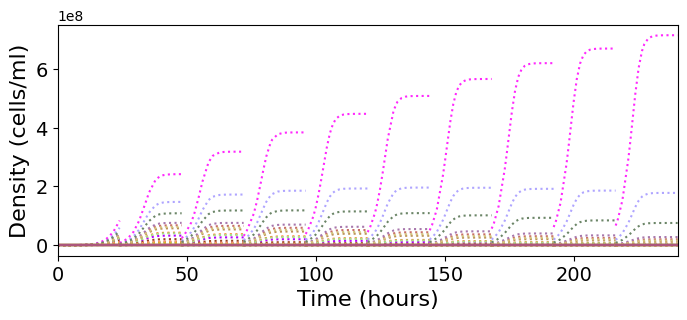

Exporting ./figures/N10/sim_densityT_N10_A0e-2.pdf


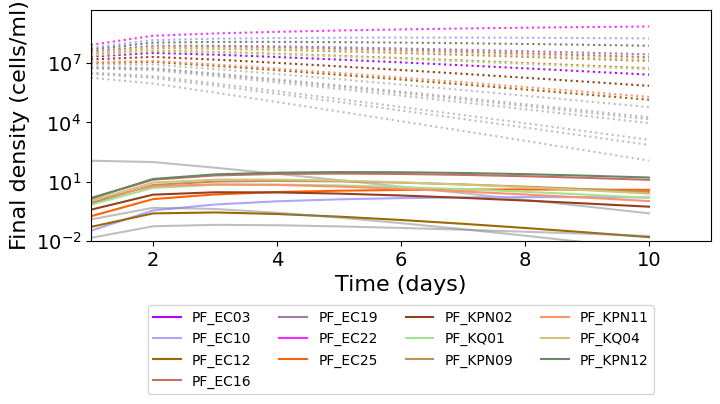

Amax=[array([32., 32., 32., 32., 32., 32., 32., 32., 32., 32.])]
istrains=[1, 2, 6, 9, 11, 15, 18, 20, 21, 24, 25, 26, 29, 34, 37, 38, 39, 41, 43, 45]
.Exporting ./figures/N10/sim_density_N10_A3200e-2.pdf


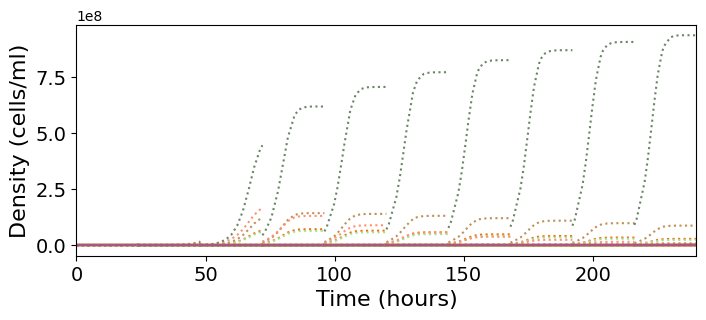

Exporting ./figures/N10/sim_densityT_N10_A3200e-2.pdf


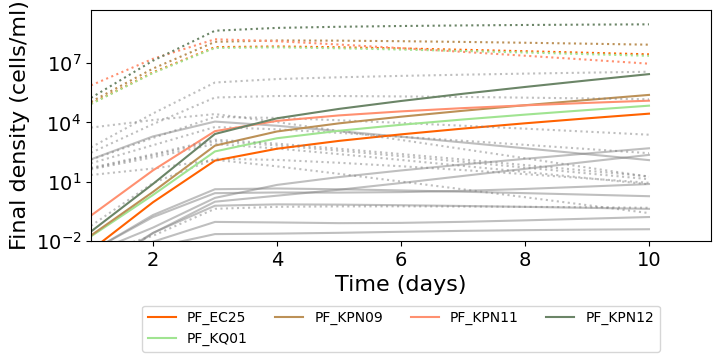

Amax=[array([1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024., 1024.,
       1024.])]
istrains=[1, 2, 6, 9, 11, 15, 18, 20, 21, 24, 25, 26, 29, 34, 37, 38, 39, 41, 43, 45]
.Exporting ./figures/N10/sim_density_N10_A102400e-2.pdf


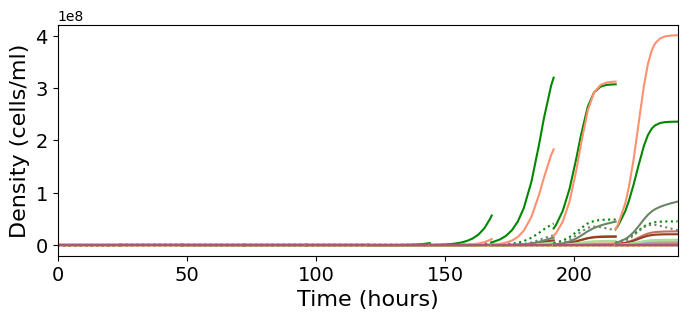

Exporting ./figures/N10/sim_densityT_N10_A102400e-2.pdf


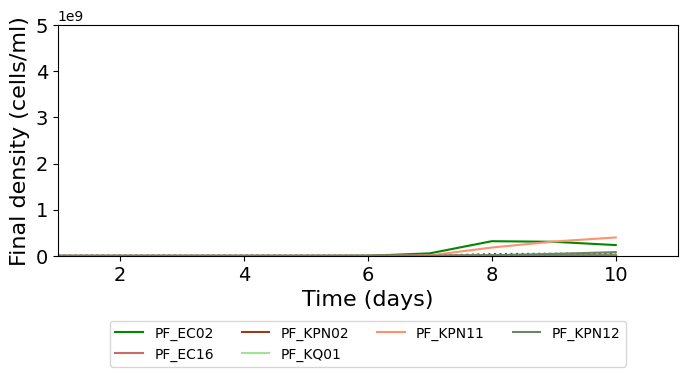

In [16]:

istrains=strains_subset


for Amax in [0, 2**5, 2**10]: # Amax_values:
  As_norm=[np.ones(num_days)]
  this_As = [Amax * a for a in As_norm]
  print("Amax=%s"%this_As)
  print("istrains=%s"%istrains)

  Btots, BpEs, BpKs, BfEs, BfKs, freqpEs, freqpKs, ts, ys, params = simulate_environments_multistrain(model_params, istrains, this_As, type_experiment)

  for i, E in enumerate(this_As):
    density_path="%ssim_density_N%s_A%se-2.pdf"%(figPathN, num_days, Amax*100)
    plotTransfers(istrains, ts[i], ys[i], params[i], density_path)

    densityT_path="%ssim_densityT_N%s_A%se-2.pdf"%(figPathN, num_days, Amax*100)
    plotTransfersFinalPoint(istrains, ts[i], ys[i], params[i], densityT_path)